In [10]:
from typing import *

import warnings
warnings.filterwarnings('ignore')

from math import sqrt
from numbers import Real

import functools
import itertools
from itertools import islice

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.figure import Figure, SubFigure
from matplotlib.axes import Axes


import seaborn as sns

import numpy as np
import pandas as pd

from constraints import *
from dataset import *

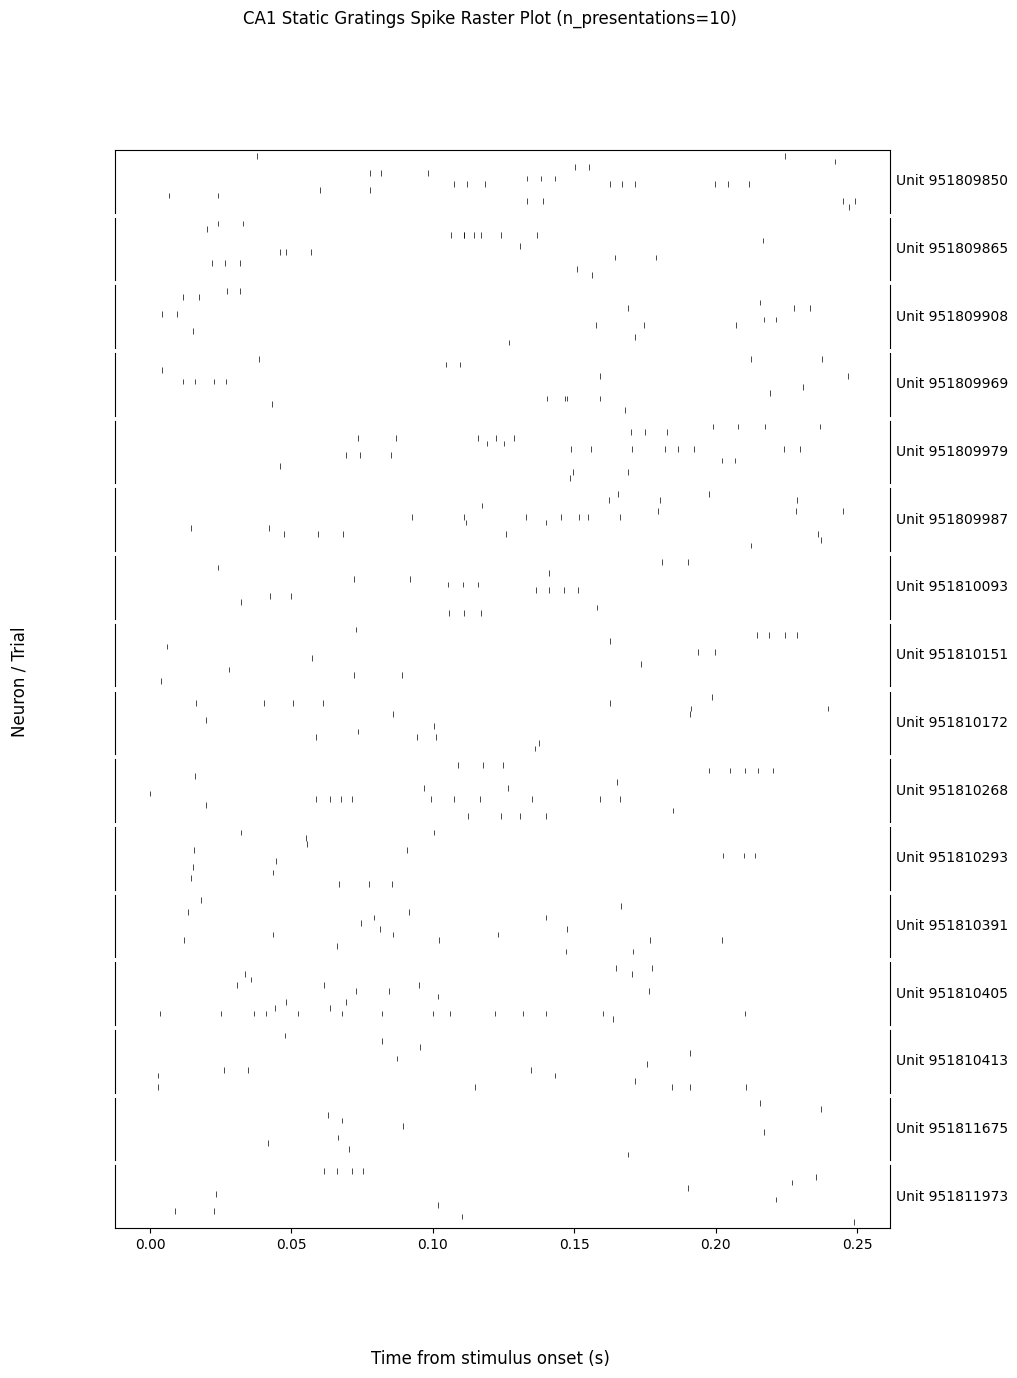

In [66]:
def plot_raster(stimulus_name: str,
                window: tuple[float, float] = (-0.5, 1.0),
                n_presentations: int = 10,
                line_width: float = 0.5,
                line_height: float = 0.8,
                row_spacing: float = 0.4,
                session: Session = CURRENT_SESSION,                
                **field_constraints: ConstraintLike
                ):
  df = filter_df(get_presentationwise_spike_times(session=session, stimulus_name=stimulus_name, **field_constraints),
                 time_since_stimulus_presentation_onset = RANGE(window[0], window[1]))
  fig, axs = plt.subplots(df['unit_id'].nunique(), 1, squeeze=False, sharex=True,
                          figsize=(10, (df['unit_id'].nunique() * (n_presentations + 1) - 1) * line_height * 0.1),
                          gridspec_kw={'hspace': line_height * 0.1})
  axs = axs.flatten()
  time_limits = df['time_since_stimulus_presentation_onset'].agg(['min', 'max'])
  for (unit_id, df), ax in zip(df.groupby('unit_id'), axs):
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(f"Unit {unit_id}", rotation='horizontal', va='center', ha='left')
    if ax is not axs[0]:
      ax.spines['top'].set_visible(False)
    if ax is not axs[-1]:
      ax.spines['bottom'].set_visible(False)
      ax.tick_params(axis='x', length=0)
    ax.set_yticks([])
    for y, (_, df) in enumerate(islice(df.groupby('stimulus_presentation_id'), n_presentations)):
      ax.vlines(df['time_since_stimulus_presentation_onset'], y*line_height, (y+1)*line_height, color='black', linewidth = line_width)
  fig.supxlabel("Time from stimulus onset (s)")
  fig.supylabel("Neuron / Trial")
  fig.tight_layout()
  return fig

fig = plot_raster(structure_acronym='CA1', stimulus_name='static_gratings')
fig.suptitle(f"CA1 Static Gratings Spike Raster Plot (n_presentations=10)")
fig.show()
fig.savefig(IMAGE_DIR / "CA1_static_gratings_raster.svg")

In [70]:
df = get_spike_info(use_rates=True, stimulus_name='static_gratings')

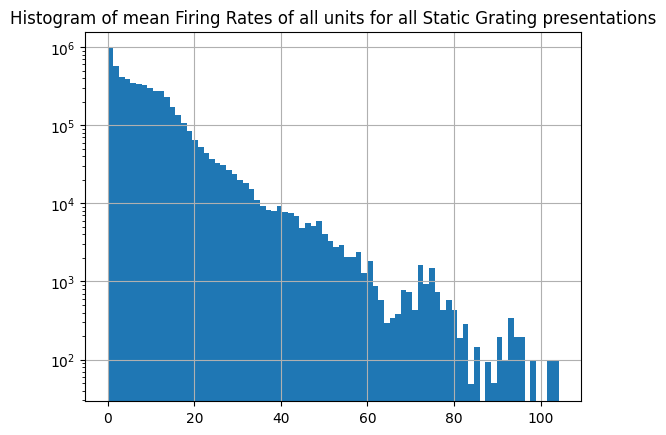

In [73]:
df['spike_mean'].hist(bins=80, log=True)
plt.title("Histogram of mean Firing Rates of all units for all Static Grating presentations")
plt.savefig(IMAGE_DIR / 'presentation_unit')
plt.show()

In [6]:
import matplotlib.pyplot as plt


def get_units(df: pd.DataFrame):

    groupby_col = 'unit_id'
    df_unit = df.groupby(groupby_col)
    units_df = pd.DataFrame(df[groupby_col].unique(), columns=[groupby_col])

    units_df['mean'] = units_df[groupby_col].apply(lambda x: df_unit.get_group(x)['spike_mean'].mean())
    units_df['std'] = units_df[groupby_col].apply(lambda x: df_unit.get_group(x)['spike_mean'].std())

    units_df['region'] = units_df[groupby_col].apply(lambda x: df_unit.get_group(x)['structure_acronym'].unique()[0])
    return units_df

orientations = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0] 

units_df = get_units(df)
units_list = [get_units(df[df['orientation'] == c]) for c in orientations]

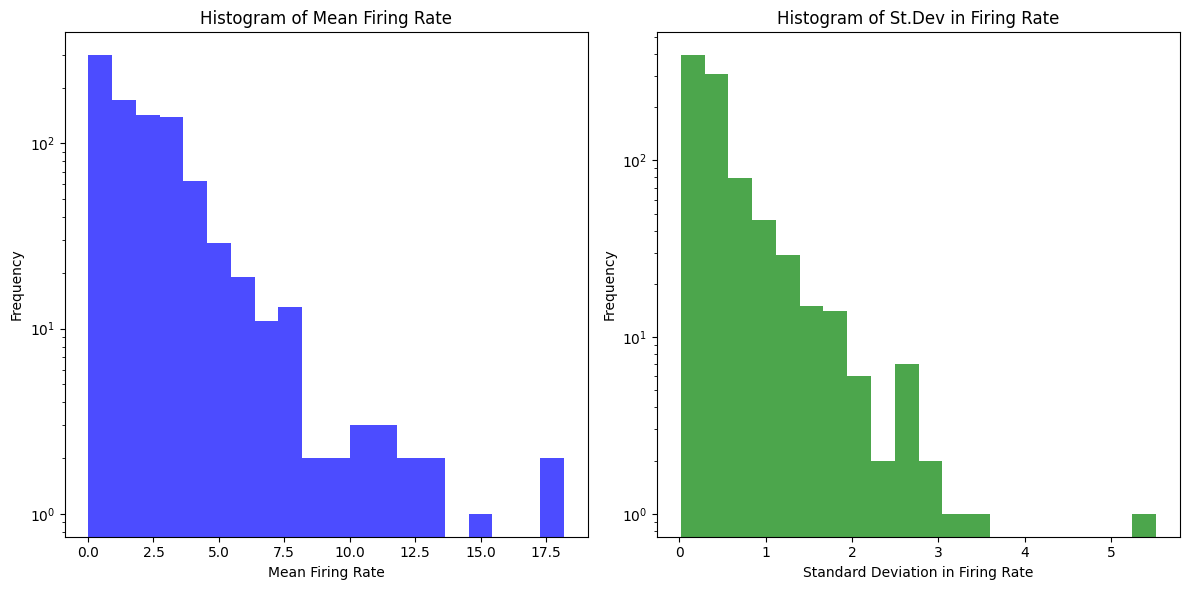

In [ ]:
import matplotlib.pyplot as plt

def plot_firing_rate_histograms(units_df):
    """
    Plots histograms of the mean and standard deviation of firing rates from a DataFrame.
    
    Args:
        units_df (pd.DataFrame): DataFrame with 'mean' and 'std' columns representing firing rates.
    """
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot histogram for 'mean'
    axes[0].hist(units_df['mean'], bins=20, color='blue', alpha=0.7, log=True)
    axes[0].set_title('Histogram of Mean Firing Rate')
    axes[0].set_xlabel('Mean Firing Rate')
    axes[0].set_ylabel('Frequency')
    
    # Plot histogram for 'std'
    axes[1].hist(units_df['std'], bins=20, color='green', alpha=0.7, log=True)
    axes[1].set_title('Histogram of St.Dev in Firing Rate')
    axes[1].set_xlabel('Standard Deviation in Firing Rate')
    axes[1].set_ylabel('Frequency')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

plot_firing_rate_histograms(units_df)

In [75]:
units_df.groupby('region').apply(len)

region
CA1       16
CA3       15
DG         7
IGL        5
IntG       2
LGd        4
VISal     71
VISam     60
VISl      38
VISp      63
VISpm     19
VISrl     44
grey     558
dtype: int64

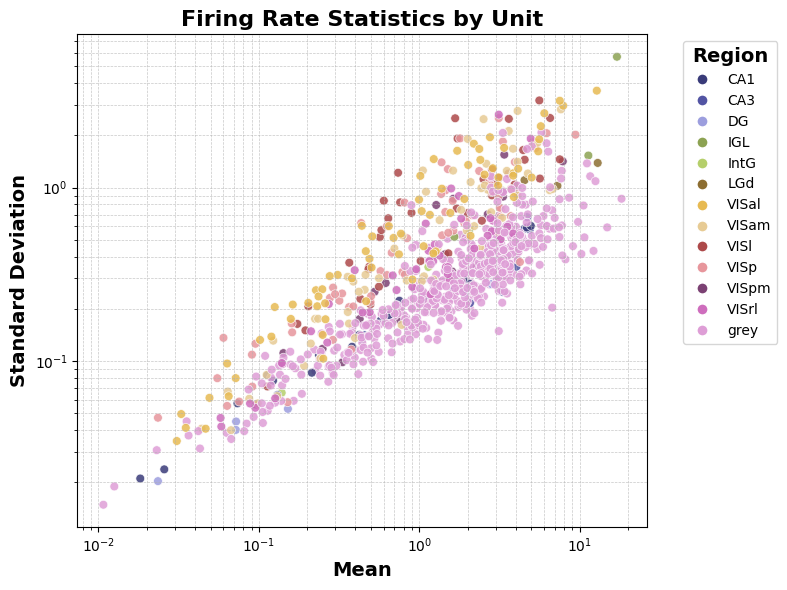

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_firing_rate_scatter(units_df: pd.DataFrame, title: str='Firing Rate Statistics by Unit'):
    """
    Plots a scatter plot of mean vs. standard deviation of firing rates, colored by region.
    
    Args:
        units_df (pd.DataFrame): DataFrame with 'mean', 'std', and 'region' columns.
    """
    plt.figure(figsize=(8, 6))

    # Prepare categories
    region_cats = units_df['region'].astype('category')
    region_codes = region_cats.cat.codes
    region_names = region_cats.cat.categories

    # Use the updated colormap getter
    cmap = plt.get_cmap('tab20b', len(region_names))  # <-- fixed line

    # Create scatter plot
    scatter = plt.scatter(units_df['mean'], units_df['std'],
                          s=40, c=region_codes,
                          cmap=cmap, alpha=0.85, edgecolors='w', linewidth=0.5,
                          vmin=0, vmax=len(region_names)-1)

    # Set log scales and labels
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Mean', fontsize=14, fontweight='bold')
    plt.ylabel('Standard Deviation', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')

    # Create custom legend
    handles = [Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=cmap(i / (len(region_names)-1)),
                      markersize=8, label=region)
               for i, region in enumerate(region_names)]
    legend = plt.legend(handles=handles, title='Region',
                        bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=14)
    legend.get_title().set_fontweight('bold')

    # Display grid and minor ticks
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


plot_firing_rate_scatter(units_df)

In [ ]:
@overload
def plot_polar_orientation_spike_rates(
    fig: None, *,
    subfigures_kw: dict[str, Any] = {},
    subplots_kw: dict[str, Any] = {'subplot_kw': {'projection': 'polar'}, 'sharey': True},
    **kwargs
) -> tuple[Figure, dict[str, SubFigure], dict[tuple[str, int], Axes]]:
  ...
@overload
def plot_polar_orientation_spike_rates(
    fig: Figure, *,
    subfigures_kw: dict[str, Any] = {},
    subplots_kw: dict[str, Any] = {'subplot_kw': {'projection': 'polar'}, 'sharey': True},
    **kwargs
) -> tuple[Figure, dict[str, SubFigure], dict[tuple[str, int], Axes]]:
  ...
@overload
def plot_polar_orientation_spike_rates(
    fig: SubFigure, *,
    subfigures_kw: dict[str, Any] = {},
    subplots_kw: dict[str, Any] = {'subplot_kw': {'projection': 'polar'}, 'sharey': True},
    **kwargs
) -> tuple[SubFigure, dict[str, SubFigure], dict[tuple[str, int], Axes]]:
  ...
def plot_polar_orientation_spike_rates(
    fig: Optional[Figure|SubFigure] = None, *, 
    subfigures_kw: dict[str, Any] = {},
    subplots_kw: dict[str, Any] = {'subplot_kw': {'projection': 'polar'}, 'sharey': True},
    **kwargs
) -> tuple[Figure|SubFigure, dict[str, SubFigure], dict[tuple[str, int], Axes]]:
    """Return a plot of spike rate vs. orientation for each unit in each region.

    `kwargs` accepts all values `get_spike_info` does."""
    def min_difference(seq: Sequence[Real]) -> Real:
        "Return the minimum absolute difference between different items in `seq`."
        return min(min(abs(i1 - i2) for i2 in seq if i2 is not i1) for i1 in seq)

    add_field_constraint('orientation', NOT(EQ('null')), kwargs)

    df = get_spike_info(use_rates=True, **kwargs) \
      .reset_index() \
      .groupby('structure_acronym')
  
    n = int(sqrt(len(df_groupby)))

    orientation_delta = min_difference(df_spike['orientation'].unique())

    if fig is None:
        fig = plt.figure()
    figs = fig.subfigures(n, n, squeeze=False, **subfigures_kw).flatten()
    region_subfigs = {}
    region_unit_axs = {}
    for subfig, (region, df) in zip(figs, df):
        region_subfigs[region] = subfig
        n = int(sqrt(len(df['unit_id'].unique())))
        axs = subfig.subplots(n, n, squeeze=False, **subplots_kw).flatten()
        for ax, (unit_id, df) in zip(axs, df.groupby('unit_id')):
            region_unit_axs[(region, unit_id)] = ax
            df_data = df.groupby('orientation')[['spike_mean']].mean().reset_index()
            df_data['orientation'] *= np.pi / 180
            ax.bar('orientation', 'spike_mean', width = np.pi * orientation_delta / 180, data=df_data)
    return fig, region_subfigs, region_unit_axs

for stimulus_name in ['static_gratings', 'drifting_gratings']:
    fig = plt.figure()
    _, region_subfigs, region_unit_axs = plot_polar_orientation_spike_rates(
      fig=fig.subfigures(2, 1, height_ratios=[0.05, 0.95])[1],
      stimulus_name=EQ(stimulus_name), isi_violations=RANGE(None, 0.7))
    fig.suptitle(f'{stimulus_name} orientation spike rates')
    for region, subfig in region_subfigs.items():
        subfig.suptitle(region)
    for (region, unit_id), ax in region_unit_axs.items():
        ax.set_title('')
        ax.set_xticks([0.0], labels=[''])
        ax.set_yticks([])
    fig.savefig(IMAGE_DIR / f'{stimulus_name}_orientation_spike_rates.svg')

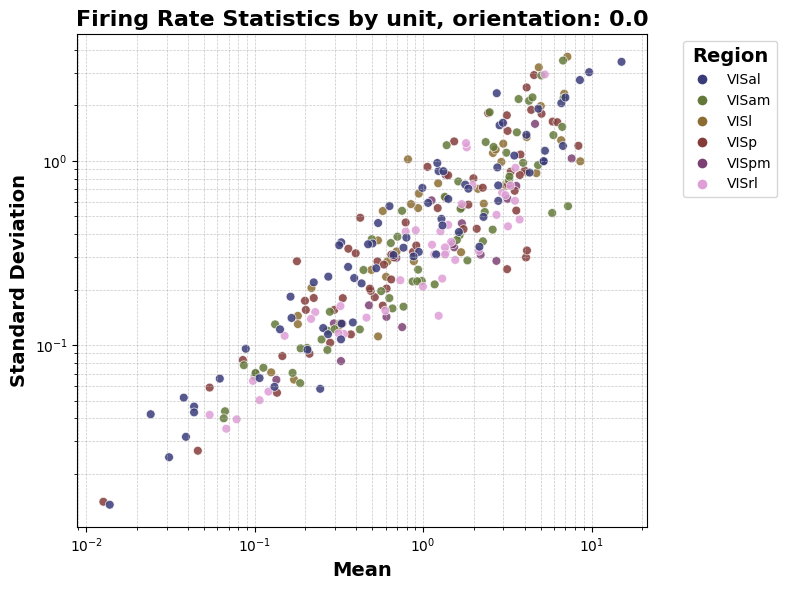

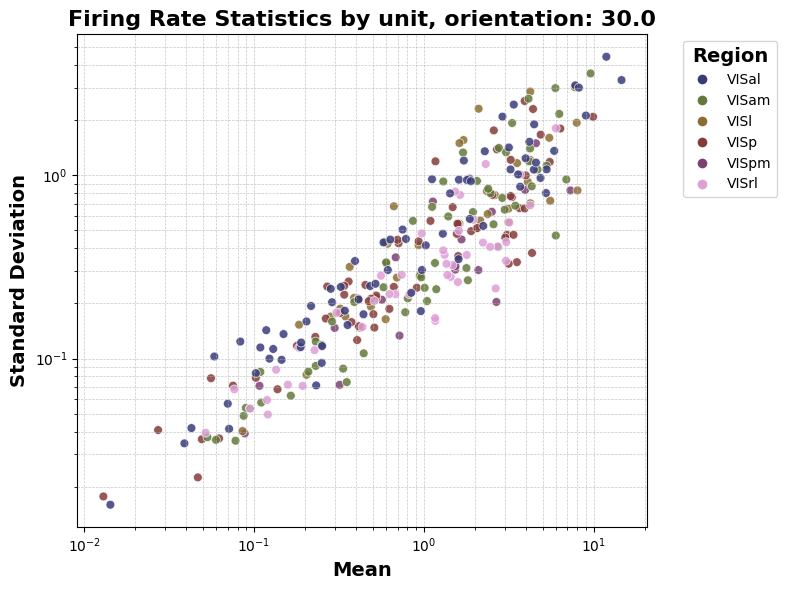

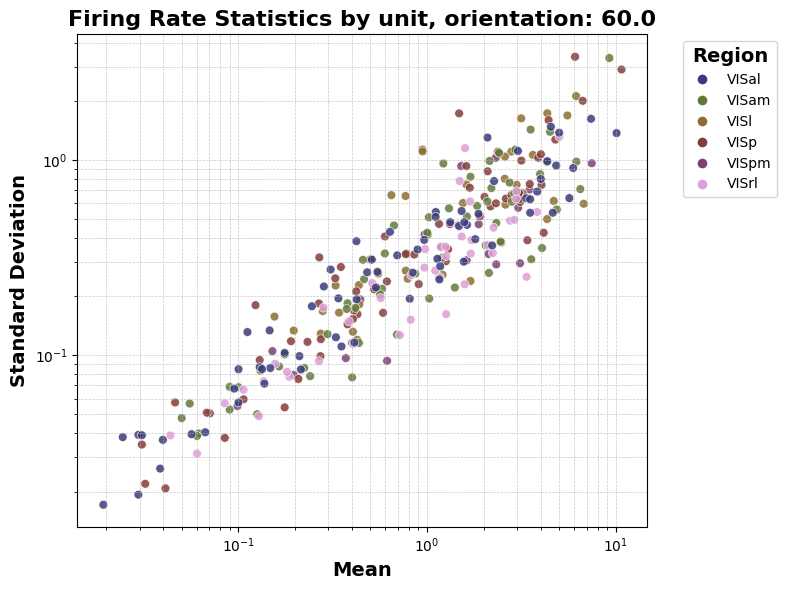

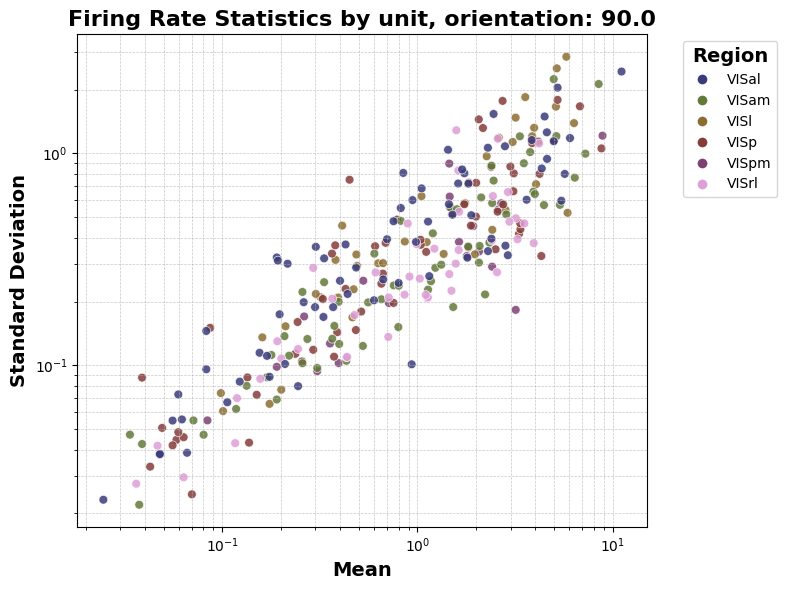

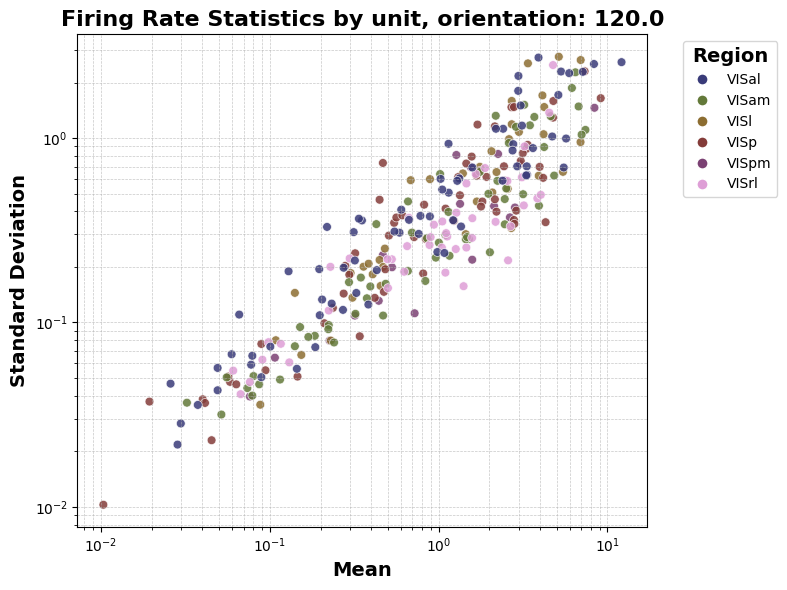

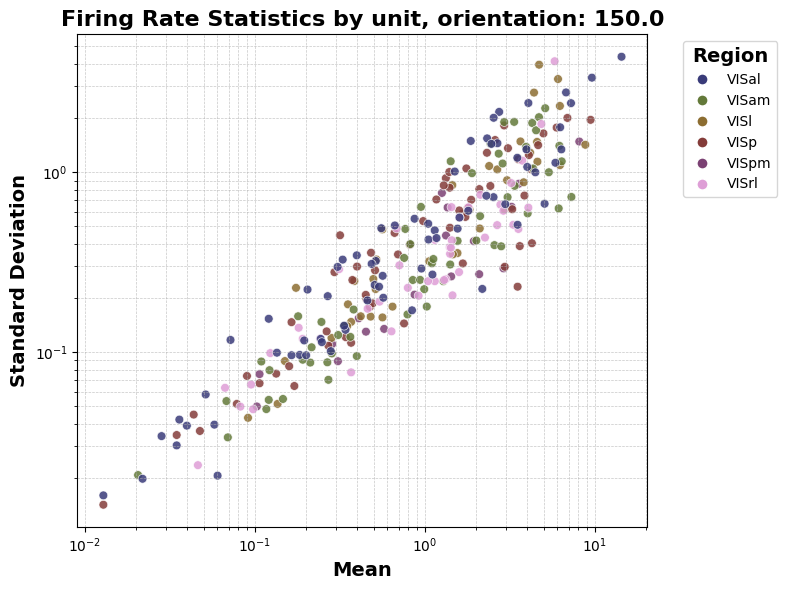

In [15]:
for i in range(len(orientations)):
    d = units_list[i]
    if d.shape[0] > 0:
        d = d[d['region'].str.startswith('VIS')]
        plot_firing_rate_scatter(d, title=f'Firing Rate Statistics by unit, orientation: {orientations[i]}')

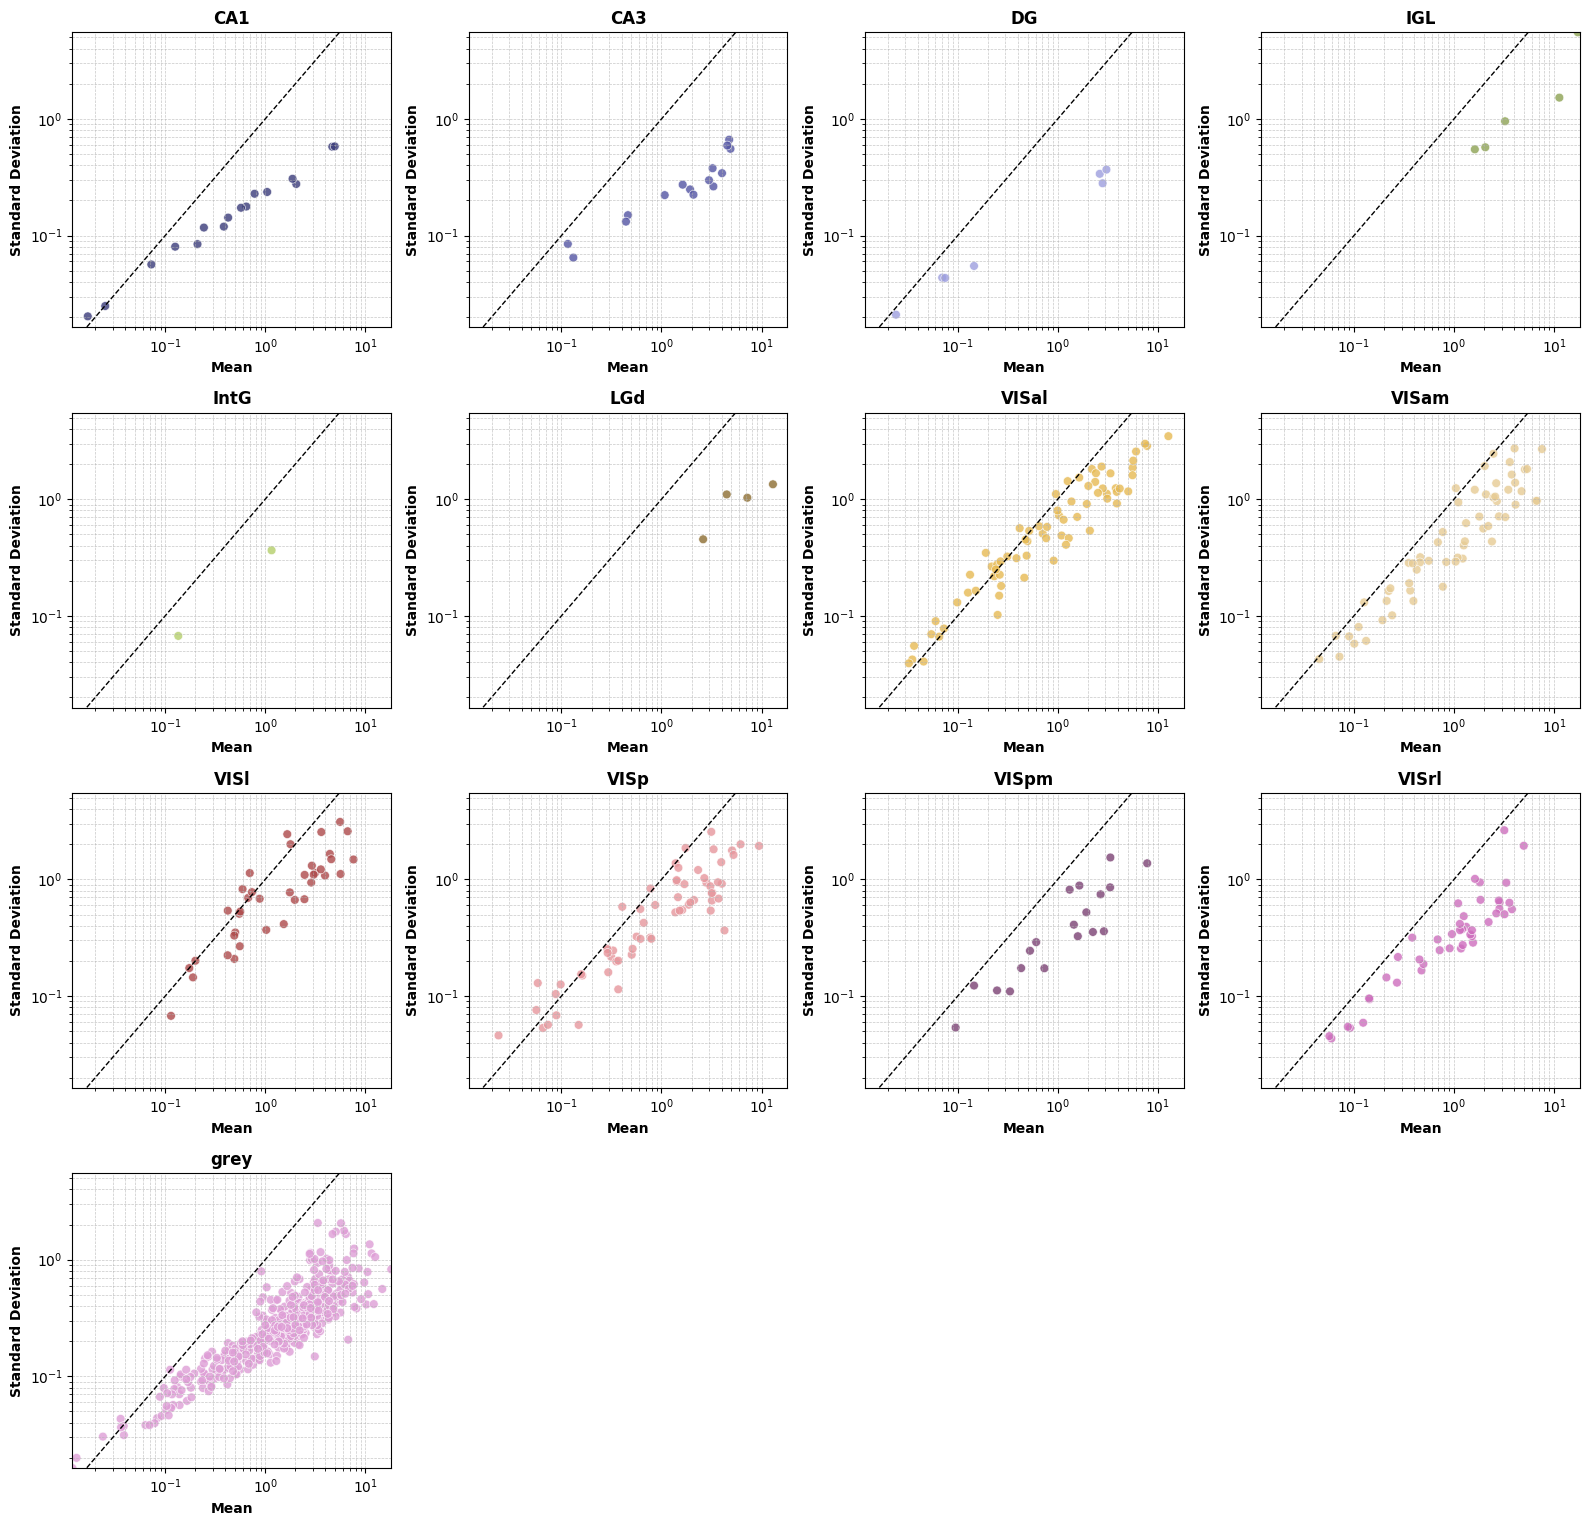

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare categories
region_cats = units_df['region'].astype('category')
region_codes = region_cats.cat.codes
region_names = region_cats.cat.categories

# Set up the figure
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

# Use the categorical colormap
cmap = plt.cm.get_cmap('tab20b', len(region_names))

# For each region, plot in its own subplot
for i, region in enumerate(region_names):
    ax = axes[i]
    region_mask = (units_df['region'] == region)

    # Plot points, colored by global region codes
    sc = ax.scatter(units_df.loc[region_mask, 'mean'],
                    units_df.loc[region_mask, 'std'],
                    s=40,
                    c=region_codes[region_mask],  # Pass the region codes directly
                    cmap=cmap,
                    vmin=0, vmax=len(region_names)-1,  # Normalize across ALL regions
                    alpha=0.8, edgecolors='w', linewidth=0.5)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(region, fontsize=12, fontweight='bold')
    ax.set_xlabel('Mean', fontsize=10, fontweight='bold')
    ax.set_ylabel('Standard Deviation', fontsize=10, fontweight='bold')
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.minorticks_on()

    # Set consistent axis limits
    ax.set_xlim(units_df['mean'].min(), units_df['mean'].max())
    ax.set_ylim(units_df['std'].min(), units_df['std'].max())

    # Plot y=x line on the log-log scale
    x_vals = np.linspace(units_df['mean'].min(), units_df['mean'].max(), 100)
    ax.plot(x_vals, x_vals, color='k', linestyle='--', linewidth=1)  # y = x line

# Hide any empty subplots (the last 3)
for j in range(len(region_names), 16):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()


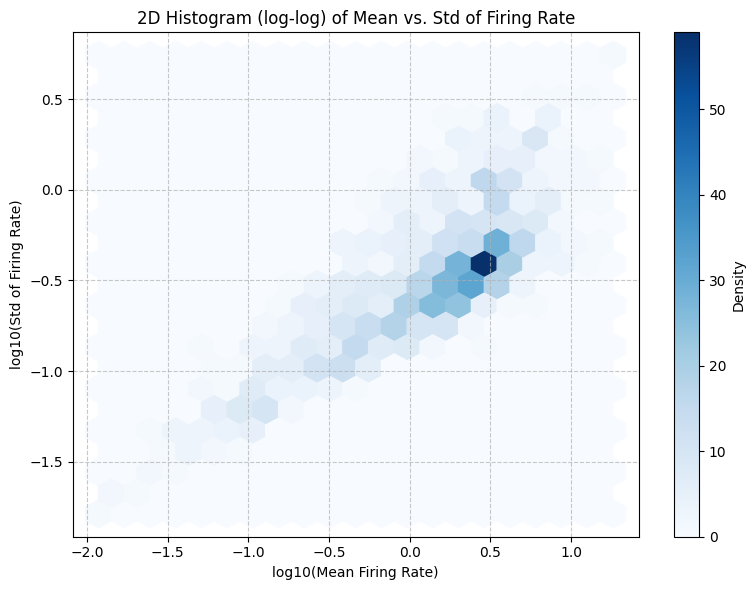

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform mean and std (log10)
log_mean = np.log10(units_df['mean'])
log_std = np.log10(units_df['std'])

# Create 2D hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(log_mean, log_std, gridsize=20, cmap='Blues')

# Add color bar to indicate density
plt.colorbar(label='Density')

# Set labels and title
plt.xlabel('log10(Mean Firing Rate)')
plt.ylabel('log10(Std of Firing Rate)')
plt.title('2D Histogram (log-log) of Mean vs. Std of Firing Rate')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [49]:
print(f'There are {df.index.get_level_values("unit_id").nunique()} unique units in total')

There are 902 unique units in total
